In [1]:
import os
import re
import glob
import pandas as pd
import scipy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from Bio.Blast import NCBIWWW
from Bio import SeqIO
import seaborn as sns
from matplotlib import gridspec
from itertools import combinations
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


# function to create colour dictionaries from a colour map and a list of items
def colourDict(data,cmap=mpl.cm.viridis,sort=False):
    """
    returns a dictionary of unique data_items:colour hex code, normalised
    takes a list of items and a cmap as mpl.cm.name. If sort = False, the function takes an ordered list of unique elements
    """
    cmap=cmap # default viridis
    data_unique=data if sort == False else list(set(data)) # includes nan values as a key. That is desirable sometimes
    norm = mpl.colors.Normalize(vmin=0, vmax=len(data_unique))
    colors = [cmap(norm(value)) for value in range(len(data_unique))]
    return dict(zip(data_unique,colors))

# Pairwise Fst calculations from poolfstats

In [63]:
glbfst = pd.read_csv('./GM_SNPs_Fst_2023/pairwisefst_minmaf5_2023.txt', sep = '\t') #, index_col = 'pairwisefst')
# NaN in diagonal have been replaced by zeros
labeldict = {'P13454_101':'Gm\nmacrostachys A',
             'P13454_102':'Gm\nmacrostachys S',
             'P13454_103':'Gm\nacaulis S',
             'P13454_104':'Gm\nacaulis A'}
glbfst['samples'] = glbfst['pairwisefst'].map(labeldict)
glbfstlab = glbfst.rename(columns = labeldict)
glbfstlab.set_index('samples', inplace = True)
glbfstlab.drop(columns = 'pairwisefst', inplace = True)
glbfstlab

Gm\nmacrostachys A  Gm\nmacrostachys S  Gm\nacaulis S  \
samples                                                                     
Gm\nmacrostachys A            0.000000           -0.004520       0.106826   
Gm\nmacrostachys S           -0.004520            0.000000       0.118267   
Gm\nacaulis S                 0.106826            0.118267       0.000000   
Gm\nacaulis A                 0.142671            0.155736       0.001806   

                    Gm\nacaulis A  
samples                            
Gm\nmacrostachys A       0.142671  
Gm\nmacrostachys S       0.155736  
Gm\nacaulis S            0.001806  
Gm\nacaulis A            0.000000

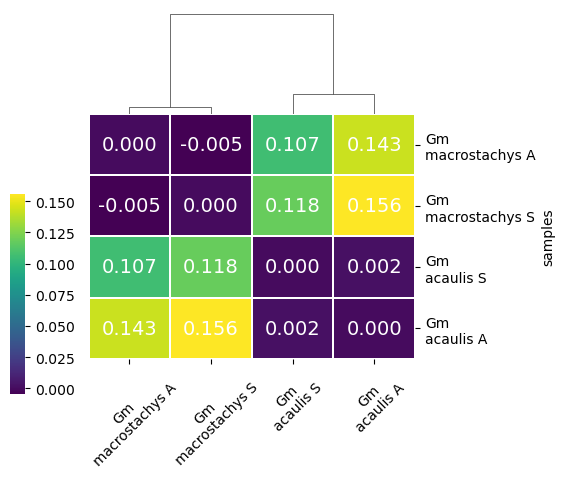

In [64]:
# fig,ax=plt.subplots(figsize=(5,5),facecolor='w')

labelcolor='#4f4f4f'

# 'fontweight':'bold' #e3e3e3
hm = sns.clustermap(glbfstlab, figsize = (5,5), row_cluster = False, dendrogram_ratio = (.01, .3),
     cbar_pos = (-0.12, .2, .03, .4), cmap = 'viridis', linewidths = .75,
     annot = True, fmt = '.3f', annot_kws = {'fontsize':14,'color':'w'})

plt.setp(hm.ax_heatmap.xaxis.get_majorticklabels(), rotation=45)

# plt.savefig('../figures//Cor_allvariables_20220812.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
%%bash
# pre process the files *glb_sliding10m.txt
for i in *glb_sliding10m.txt; do
    sed -i 's/"//g' $i
    pair=$(echo "${i%.*}" | sed 's/glb_sliding10m//g');
    echo $pair
    sed -i "s/MultiLocusFst/MultiLocusFst_$pair/g" $i
done

# Process files and create dataframe

In [65]:
# upload files
path=os.getcwd()
ext='./GM_SNPs_Fst_2023/*glb_sliding10m.txt'

data=pd.DataFrame(columns=['chr','position','cumulatedposition','multilocusfst','pair'])

for filename in glob.glob(os.path.join(path,'%s'%(ext))):
    pair=filename.split('/')[-1].split('glb')[0]
    tempdata=pd.read_csv(filename,names=['chr','position','cumulatedposition','multilocusfst'],
                         skiprows=1,sep=' ')
    tempdata['pair']=[pair]*len(tempdata)
    data=pd.concat([data,tempdata], sort=True)
data.reset_index(inplace=True)
data

index                                    chr cumulatedposition  \
0           0              NC_025997.1_RagTag_RagTag          23524883   
1           1              NC_026004.1_RagTag_RagTag          36946161   
2           2              NC_026007.1_RagTag_RagTag          47938388   
3           3              NC_026007.1_RagTag_RagTag          47938429   
4           4  NODE_100003_length_1654_cov_23.324578          47940000   
...       ...                                    ...               ...   
170737  28452           NW_011587330.1_RagTag_RagTag          84827954   
170738  28453           NW_011588234.1_RagTag_RagTag          84829008   
170739  28454           NW_011588234.1_RagTag_RagTag          84829031   
170740  28455           NW_011588234.1_RagTag_RagTag          84829059   
170741  28456           NW_011588234.1_RagTag_RagTag          84829085   

        multilocusfst     pair  position  
0           -0.014640  pools12  23524883  
1            0.016542  pools12  13421278  
2           -0.004853  pools12  10992227  
3           -0.026491  pools12  10992268  
4           -0.041583  pools12      1571  
...               ...      ...       ...  
170737       0.006760  pools34      9443  
170738      -0.012755  pools34      1054  
170739      -0.017269  pools34      1077  
170740      -0.013075  pools34      1105  
170741      -0.010724  pools34      1131  

[170742 rows x 6 columns]

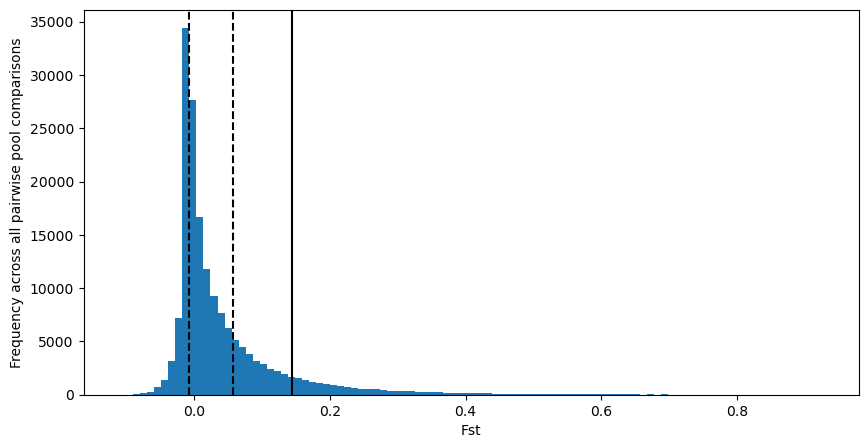

In [66]:
# distribution of Fst values across SNP positions and pairwise comparisons
fig,ax = plt.subplots(figsize = (10,5), facecolor = 'w')

ax.hist(data['multilocusfst'], bins=100)
ax.axvline(x = data['multilocusfst'].quantile(0.25), c = 'k', ls = '--')
ax.axvline(x = data['multilocusfst'].quantile(0.75), c = 'k', ls = '--')
ax.axvline(x = data['multilocusfst'].quantile(0.9), c = 'k')
plt.ylabel('Frequency across all pairwise pool comparisons')
plt.xlabel('Fst')
plt.show()

In [67]:
data['pair'].unique()

array(['pools12', 'pools13', 'pools14', 'pools23', 'pools24', 'pools34'],
      dtype=object)

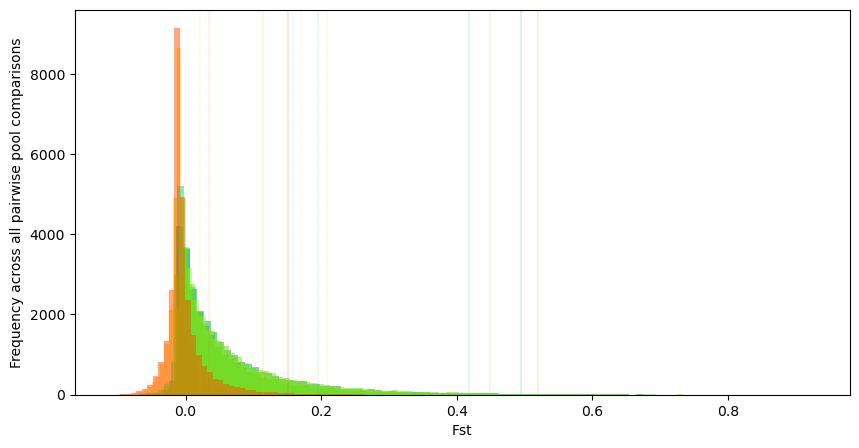

In [72]:
# colour dic with orange-hues for within morphotype comparisons and green-blue-ish hues for between morphotyes

paircol = {'pools12':'#FFC000',
           'pools13':'#24D86D',
           'pools14':'#00AC46',
           'pools23':'#98F229',
           'pools24':'#78DA00',
           'pools34':'#FF4C00'}

fig,ax = plt.subplots(figsize = (10,5), facecolor = 'w')

for pair in list(data['pair'].unique()):
    temp = data[data['pair'] == pair]
    ax.hist(temp['multilocusfst'], bins=100, color = paircol[pair], alpha = 0.5)
    ax.axvline(x = temp['multilocusfst'].quantile(0.90), c = paircol[pair], alpha = 0.6, ls = '--', lw = 0.2)
    ax.axvline(x = temp['multilocusfst'].quantile(0.99), c = paircol[pair], alpha = 1, lw = 0.2)
plt.ylabel('Frequency across all pairwise pool comparisons')
plt.xlabel('Fst')
plt.show()

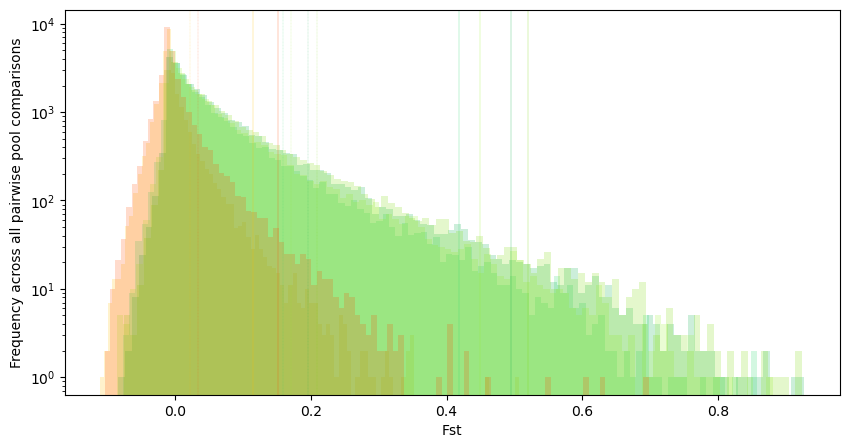

In [78]:
# colour dic with orange-hues for within morphotype comparisons and green-blue-ish hues for between morphotyes

paircol = {'pools12':'#FFC000',
           'pools13':'#24D86D',
           'pools14':'#00AC46',
           'pools23':'#98F229',
           'pools24':'#78DA00',
           'pools34':'#FF4C00'}

fig,ax = plt.subplots(figsize = (10,5), facecolor = 'w')

for pair in list(data['pair'].unique()):
    temp = data[data['pair'] == pair]
    ax.hist(temp['multilocusfst'], bins=100, color = paircol[pair], alpha = 0.2, lw = 2)
    ax.axvline(x = temp['multilocusfst'].quantile(0.90), c = paircol[pair], alpha = 0.6, ls = '--', lw = 0.2)
    ax.axvline(x = temp['multilocusfst'].quantile(0.99), c = paircol[pair], alpha = 1, lw = 0.2)
ax.set_yscale('log')
plt.ylabel('Frequency across all pairwise pool comparisons')
plt.xlabel('Fst')
plt.show()

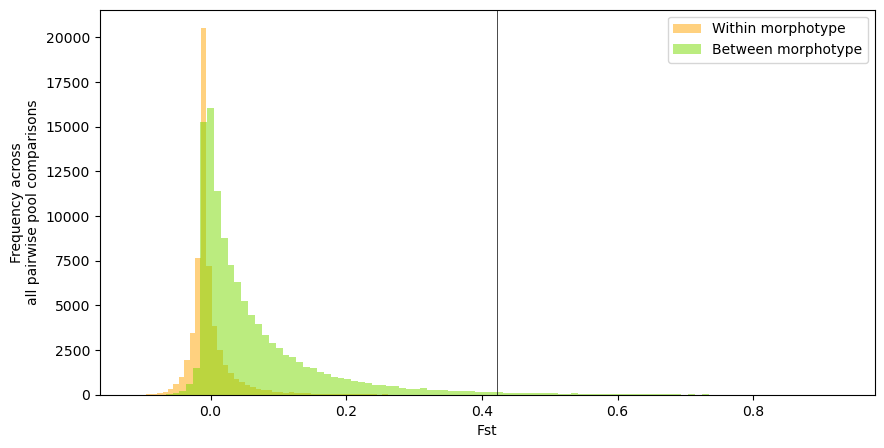

In [86]:
# colour dic with orange-hues for within morphotype comparisons and green-blue-ish hues for between morphotyes

paircol = {'pools12':'#FFC000',
           'pools13':'#24D86D',
           'pools14':'#00AC46',
           'pools23':'#98F229',
           'pools24':'#78DA00',
           'pools34':'#FF4C00'}

fig,ax = plt.subplots(figsize = (10,5), facecolor = 'w')

within = data[data['pair'].isin(['pools12','pools34'])]
between = data[data['pair'].isin(['pools13','pools14','pools23','pools24'])]

ax.hist(within['multilocusfst'], bins=100, color = '#FFA500', alpha = 0.5, label = 'Within morphotype')
ax.hist(between['multilocusfst'], bins=100, color = '#78DA00', alpha = 0.5, label = 'Between morphotype')

ax.axvline(x = data['multilocusfst'].quantile(0.99), c = 'k', alpha = 1, lw = 0.5)
plt.legend(loc = 'upper right', bbox_to_anchor = (0.5, 0.5, 0.5, 0.5))

plt.ylabel('Frequency across\nall pairwise pool comparisons')
plt.xlabel('Fst')
plt.show()

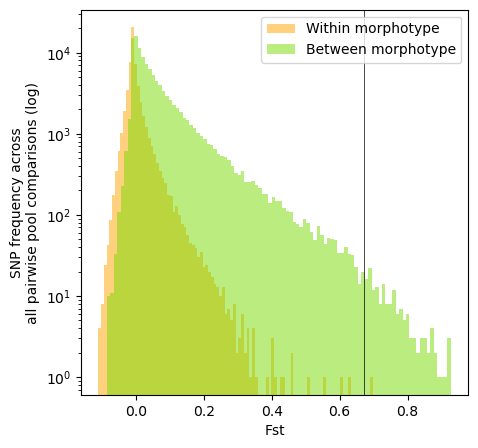

In [95]:
# colour dic with orange-hues for within morphotype comparisons and green-blue-ish hues for between morphotyes

paircol = {'pools12':'#FFC000',
           'pools13':'#24D86D',
           'pools14':'#00AC46',
           'pools23':'#98F229',
           'pools24':'#78DA00',
           'pools34':'#FF4C00'}

fig,ax = plt.subplots(figsize = (5,5), facecolor = 'w')

within = data[data['pair'].isin(['pools12','pools34'])]
between = data[data['pair'].isin(['pools13','pools14','pools23','pools24'])]

ax.hist(within['multilocusfst'], bins=100, color = '#FFA500', alpha = 0.5, label = 'Within morphotype')
ax.hist(between['multilocusfst'], bins=100, color = '#78DA00', alpha = 0.5, label = 'Between morphotype')

ax.axvline(x = data['multilocusfst'].quantile(0.999), c = 'k', alpha = 1, lw = 0.5)
ax.set_yscale('log')
plt.legend(loc = 'upper right', bbox_to_anchor = (0.5, 0.5, 0.5, 0.5))

plt.ylabel('SNP frequency across\nall pairwise pool comparisons (log)')
plt.xlabel('Fst')
plt.show()

## number of SNPs between and within morphotype comparisons

Do we chose as outliers anything beyond 95% of the distribution? (Salazar et al.) or beyond 90%? or with Fst >0.9 independently of the data distribution?

It makes more sense to choose outliers based on the quantiles rather than a numberical threshold (e.g. quantile 0.999 vs. Fst value >0.9) since the numerical thershold might not have any biological relevance. More so if we are studying within species populations (or very closely related, diverging new species).

It also makes sense to estimate the quantile from the distribution of all (within and between morphotype) Fst values, this way we capture the wide variation when within and between population dynamycs are both present. e.g. If I use the 0.99 quantile for only within-morphotype comparisons to identify outliers in within-morphotype comparisons I will undoubtly find something. It is less obvious for using pairwise-specific quantiles when comparing between-morphotype pools though, but using a pairwise-specific quantile in this case also undoubtly result in outliers. It is better to use a more "independent" value.

### Global

In [33]:
# SNPs with Fst values between -0.1 and 0.1 - effectively not relevant at all
data[(data['multilocusfst'] > -0.1) & (data['multilocusfst'] < 0.1)].groupby('pair').count()

index    chr  cumulatedposition  multilocusfst  position
pair                                                             
pools12  28073  28073              28073          28073     28073
pools13  23172  23172              23172          23172     23172
pools14  21667  21667              21667          21667     21667
pools23  22643  22643              22643          22643     22643
pools24  21019  21019              21019          21019     21019
pools34  27761  27761              27761          27761     27761

In [35]:
# SNPs with Fst values below the 0.9 threshold - effectively not relevant
data[data['multilocusfst'] < 0.9].groupby('pair').count()

index    chr  cumulatedposition  multilocusfst  position
pair                                                             
pools12  28454  28454              28454          28454     28454
pools13  28457  28457              28457          28457     28457
pools14  28455  28455              28455          28455     28455
pools23  28457  28457              28457          28457     28457
pools24  28454  28454              28454          28454     28454
pools34  28456  28456              28456          28456     28456

In [36]:
# SNPs with Fst values above or equal to the 0.9 threshold - interesting to look at
data[data['multilocusfst'] >= 0.9].groupby('pair').count()

index  chr  cumulatedposition  multilocusfst  position
pair                                                           
pools14      2    2                  2              2         2
pools24      3    3                  3              3         3

In [93]:
p090 = data['multilocusfst'].quantile(0.90)
p095 = data['multilocusfst'].quantile(0.95)
p099 = data['multilocusfst'].quantile(0.99)
p0999 = data['multilocusfst'].quantile(0.999)


print('Threshold value for the 0.9 quantile: %.3f'%(p090))
print('Threshold value for the 0.95 quantile: %.3f'%(p095))
print('Threshold value for the 0.99 quantile: %.3f'%(p099))
print('Threshold value for the 0.999 quantile: %.3f'%(p0999))

Threshold value for the 0.9 quantile: 0.143
Threshold value for the 0.95 quantile: 0.220
Threshold value for the 0.99 quantile: 0.422
Threshold value for the 0.999 quantile: 0.672


In [43]:
data[data['multilocusfst'] >= p090].groupby('pair').count()

index   chr  cumulatedposition  multilocusfst  position
pair                                                            
pools12    151   151                151            151       151
pools13   3322  3322               3322           3322      3322
pools14   4542  4542               4542           4542      4542
pools23   3722  3722               3722           3722      3722
pools24   5009  5009               5009           5009      5009
pools34    328   328                328            328       328

In [44]:
data[data['multilocusfst'] >= p095].groupby('pair').count()

index   chr  cumulatedposition  multilocusfst  position
pair                                                            
pools12     40    40                 40             40        40
pools13   1589  1589               1589           1589      1589
pools14   2317  2317               2317           2317      2317
pools23   1904  1904               1904           1904      1904
pools24   2596  2596               2596           2596      2596
pools34     91    91                 91             91        91

In [94]:
data[data['multilocusfst'] >= p0999].groupby('pair').count()

index  chr  cumulatedposition  multilocusfst  position
pair                                                           
pools13     19   19                 19             19        19
pools14     52   52                 52             52        52
pools23     30   30                 30             30        30
pools24     69   69                 69             69        69
pools34      1    1                  1              1         1

### Quantile thresholds by pairwise comparison

In [ ]:
spinescol='#999999'

pools = ['p1','p2','p3','p4']
names = {'p1':'macall',
         'p2':'macsym',
         'p3':'acasym',
         'p4':'acaall'}

In [5]:
names = ['p1_p2','p1_p3','p1_p4','p2_p3','p2_p4','p3_p4']
fst = pd.read_csv('./pairwise_snp_fst_mincov10_minmaf005_block10_20221201.txt', sep ='\t', names = ['CHROM']+names, skiprows = [0])
fst

CHROM     p1_p2     p1_p3     p1_p4     p2_p3     p2_p4     p3_p4
0          1 -0.062072  0.007914  0.015681  0.001491  0.007808       NaN
1          2       NaN  0.829299  1.000000  0.788424  0.941451  0.101738
2          3       NaN  0.736624  1.000000  0.706262  0.944632  0.229578
3          4       NaN  0.829299  1.000000  0.793879  0.944632  0.115139
4          5       NaN  0.823276  1.000000  0.748042  0.931212  0.115139
...      ...       ...       ...       ...       ...       ...       ...
20639  20640 -0.057678 -0.004680 -0.004137 -0.049373 -0.046310 -0.062996
20640  20641 -0.012739  0.605879  0.535852  0.346602  0.280634       NaN
20641  20642  0.118426  0.178884  0.229038  0.432226  0.481635       NaN
20642  20643 -0.044154  0.696837  0.717818  0.498034  0.522097       NaN
20643  20644  0.085949  0.767292  0.872990  0.948449  1.000000       NaN

[20644 rows x 7 columns]

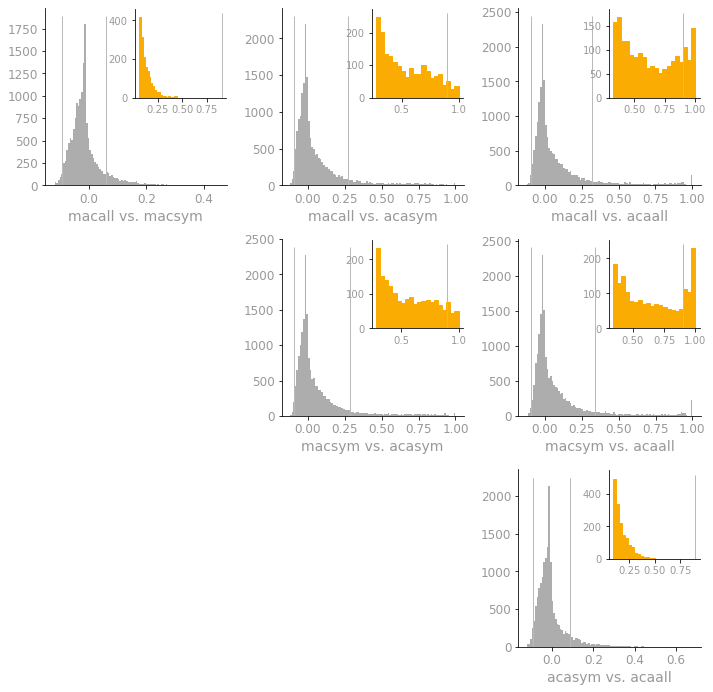

In [27]:
# we expect to find outliers in p1_p3, p2_p4, p1_p4, and p2_p3 that do not appear as outliers in p1_p2 or p3_p4
# we also need to understand the distribution of Fst values in each comparison

plt.figure(figsize=(4*4,4*4),facecolor='w')
G = gridspec.GridSpec(4,4,hspace=0.3,wspace=0.3)
spinescol='#999999'

pools = ['p1','p2','p3','p4']
names = {'p1':'macall',
         'p2':'macsym',
         'p3':'acasym',
         'p4':'acaall'}

plt.title('Distribution of Fst values between pools')

for x,y in combinations([i for i,x in enumerate(pools)],2):
    ax=plt.subplot(G[x,y])
    data975 = fst['%s_%s'%(pools[x],pools[y])].quantile(0.9)
    try:
        temp = fst[fst['%s_%s'%(pools[x],pools[y])] <= data975].copy(deep = True)
        outlier = fst[fst['%s_%s'%(pools[x],pools[y])] > data975].copy(deep = True)
        
        ax.hist(fst['%s_%s'%(pools[x],pools[y])], bins = 100, color = '#adadad')      
#         ax.hist(temp['%s_%s'%(pools[x],pools[y])], bins = 90, color = '#adadad')
#         ax.hist(outlier['%s_%s'%(pools[x],pools[y])], bins = 90, facecolor = '#faac02', edgecolor = '#faac02', lw = 1.5)
        
        ax.vlines(x = [data025, data975], ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1], color = '#bababa', lw = 1)
        
        ax.set_xlabel('%s vs. %s'%(names[pools[x]],names[pools[y]]), fontsize = 14, color = spinescol)
        
        [ax.spines[loc].set_visible(False) for loc in ['right','top']]
        plt.yticks(fontsize = 12, color = spinescol); plt.xticks(fontsize = 12, color = spinescol)
        
        if len(outlier) > 1:
            ax1 = inset_axes(ax, width = '50%', height = '50%', loc = 1, borderpad = 0.1)
            ax1.hist(outlier['%s_%s'%(pools[x],pools[y])], bins = 20, facecolor = '#faac02', edgecolor = '#faac02', lw = 1)
            ax1.vlines(x = 0.9, ymin = ax1.get_ylim()[0], ymax = ax1.get_ylim()[1], color = '#bababa', lw = 1)
            [ax1.spines[loc].set_visible(False) for loc in ['right','top']]
            plt.yticks(fontsize = 10, color = spinescol); plt.xticks(fontsize = 10, color = spinescol)            

    except:
        pass
    

plt.show()

In [28]:
# if we only look at outlier loci, definint them as SNPs with Fst >= 0.9
# then all those appear in cross-morphotypes and not within morphotyes
fst.describe()

CHROM         p1_p2         p1_p3         p1_p4         p2_p3  \
count  20644.000000  16316.000000  18359.000000  18575.000000  18334.000000   
mean   10322.500000     -0.010877      0.066329      0.087288      0.072505   
std     5959.553814      0.059053      0.184456      0.212085      0.193334   
min        1.000000     -0.123752     -0.122828     -0.123321     -0.123258   
25%     5161.750000     -0.044023     -0.033482     -0.026912     -0.031854   
50%    10322.500000     -0.019554     -0.004535      0.002491     -0.002885   
75%    15483.250000      0.001107      0.090431      0.110003      0.096611   
max    20644.000000      0.449848      1.000000      1.000000      1.000000   

              p2_p4         p3_p4  
count  18639.000000  16249.000000  
mean       0.091911     -0.004233  
std        0.218495      0.074049  
min       -0.123752     -0.122828  
25%       -0.025752     -0.046532  
50%        0.005189     -0.018705  
75%        0.113280      0.008013  
max        1.000000      0.679754

In [29]:
# we need to get lists of the indices of outlier loci for each comparison
# we also want to focus on SNPs found in all four cross morphotype comparisons
# p1_p3, p1_p4, p2_p3, p2_p4

outliers = {}
for x,y in combinations([i for i,x in enumerate(pools)],2):
    outlier = fst[fst['%s_%s'%(pools[x],pools[y])] >= 0.9].copy(deep = True)
    if len(outlier) > 1:
        outliers['%s_%s'%(pools[x],pools[y])] = list(outlier['%s_%s'%(pools[x],pools[y])].index)
                
        print('%s_%s'%(pools[x],pools[y]), 'Num. of outlier loci: ',len(outlier))
        print(outlier['%s_%s'%(pools[x],pools[y])].describe())
        print('\n')

p1_p3 Num. of outlier loci:  99
count    99.000000
mean      0.951612
std       0.039445
min       0.902466
25%       0.915727
50%       0.936568
75%       1.000000
max       1.000000
Name: p1_p3, dtype: float64


p1_p4 Num. of outlier loci:  322
count    322.000000
mean       0.961470
std        0.036890
min        0.900138
25%        0.927359
50%        0.950270
75%        1.000000
max        1.000000
Name: p1_p4, dtype: float64


p2_p3 Num. of outlier loci:  149
count    149.000000
mean       0.949938
std        0.036778
min        0.900672
25%        0.921800
50%        0.934896
75%        1.000000
max        1.000000
Name: p2_p3, dtype: float64


p2_p4 Num. of outlier loci:  447
count    447.000000
mean       0.967366
std        0.035241
min        0.902266
25%        0.933786
50%        1.000000
75%        1.000000
max        1.000000
Name: p2_p4, dtype: float64




In [31]:
from collections import Counter

selected_outliers=[]
for key,value in Counter(sorted(sum(outliers.values(),[]))).items():
    if value == 4:
        print(key,value)
        selected_outliers.append(key)
print('Number of selected outlier loci: ',len(selected_outliers))

963 4
1356 4
1814 4
1884 4
1885 4
2392 4
2393 4
2787 4
2788 4
2789 4
2989 4
3072 4
3650 4
5630 4
6671 4
6736 4
6737 4
6738 4
6883 4
6892 4
7294 4
7295 4
7296 4
7297 4
7298 4
7923 4
7937 4
8422 4
8423 4
8424 4
10237 4
10238 4
10239 4
10240 4
10831 4
10832 4
10833 4
10834 4
11112 4
11113 4
11789 4
12561 4
12562 4
12563 4
13751 4
14325 4
14566 4
14567 4
15175 4
16306 4
17050 4
17051 4
17052 4
17053 4
17054 4
17362 4
18955 4
19258 4
19315 4
19698 4
20251 4
Number of selected outlier loci:  61


In [32]:
# we need fo figure out which chromosomes the SNPs belong to.
# we can use the snp info table generated when uploading the vcf file to poolfstat
# always make sure the number of SNPs uploaded (min and max filter values) coincide with the filters applied to Fst estimation

snpinfo = pd.read_csv('./snp_info_mincov10_minmaf005_block10_20221201.txt', sep = '\t')
snpinfo

Chromosome  Position RefAllele AltAllele
1                 NC_025994.1_RagTag_RagTag  30374349         C         G
2                 NC_025994.1_RagTag_RagTag  30374353         C         T
3                 NC_025994.1_RagTag_RagTag  30374363         C         T
4                 NC_025994.1_RagTag_RagTag  30374367         C         T
5                 NC_025994.1_RagTag_RagTag  30374382         A         G
...                                     ...       ...       ...       ...
20640  NODE_9830_length_11554_cov_20.428037     11547         C         T
20641  NODE_9830_length_11554_cov_20.428037     11548         C         T
20642  NODE_9850_length_11543_cov_23.292044     11518         G         A
20643  NODE_9967_length_11475_cov_21.076270     11437         G         T
20644  NODE_9995_length_11456_cov_15.752390     11378         T         A

[20644 rows x 4 columns]

In [33]:
# add a column indicating if the SNP is a selected outline or not

snpinfo['outlier'] = ''

for index,row in enumerate(snpinfo.itertuples()):
    if index in selected_outliers:
        snpinfo.loc[index,'outlier'] = 'selected'
#         print(index,row)
snpinfo

Chromosome  Position RefAllele AltAllele  \
1                 NC_025994.1_RagTag_RagTag  30374349         C         G   
2                 NC_025994.1_RagTag_RagTag  30374353         C         T   
3                 NC_025994.1_RagTag_RagTag  30374363         C         T   
4                 NC_025994.1_RagTag_RagTag  30374367         C         T   
5                 NC_025994.1_RagTag_RagTag  30374382         A         G   
...                                     ...       ...       ...       ...   
20640  NODE_9830_length_11554_cov_20.428037     11547         C         T   
20641  NODE_9830_length_11554_cov_20.428037     11548         C         T   
20642  NODE_9850_length_11543_cov_23.292044     11518         G         A   
20643  NODE_9967_length_11475_cov_21.076270     11437         G         T   
20644  NODE_9995_length_11456_cov_15.752390     11378         T         A   

      outlier  
1              
2              
3              
4              
5              
...       ...  
20640          
20641          
20642          
20643          
20644          

[20644 rows x 5 columns]

In [34]:
snpinfo[snpinfo['outlier'] == 'selected']

Chromosome  Position RefAllele AltAllele  \
963            NW_011551488.1_RagTag_RagTag     17489         A         G   
1356           NW_011551989.1_RagTag_RagTag     64168         C         T   
1814           NW_011552785.1_RagTag_RagTag      5126         G         A   
1884           NW_011552973.1_RagTag_RagTag     27259         A         G   
1885           NW_011553003.1_RagTag_RagTag     20099         G         A   
...                                     ...       ...       ...       ...   
18955  NODE_33153_length_5093_cov_27.094482      5079         G         A   
19258  NODE_33397_length_5060_cov_27.626573      4971         G         A   
19315  NODE_33433_length_5055_cov_11.168000      5006         G         A   
19698  NODE_33818_length_5006_cov_25.112301      4956         C         T   
20251  NODE_7557_length_13127_cov_25.211750     13067         C         A   

        outlier  
963    selected  
1356   selected  
1814   selected  
1884   selected  
1885   selected  
...         ...  
18955  selected  
19258  selected  
19315  selected  
19698  selected  
20251  selected  

[61 rows x 5 columns]

In [35]:
# get a list of the contigs
# we can grep the contig from the reference
# and around 100 nucleotides before and after the position of the sequence to blast the sequence
snpinfo[snpinfo['outlier'] == 'selected'][['Chromosome','Position']].to_csv('./selected_loci_ref_20221202.txt', sep = '\t')

In [36]:
%%bash
rm selected_contigs.fasta
while read -r line;
do
    CHROM=$(echo "$line" | cut -f 2)
    POS=$(echo "$line" | cut -f 3)
    grep -A1 "$CHROM" ../ref/k55hyb_GUR2/ragtag.scaffold.fasta >> selected_contigs.fasta
done < selected_loci_ref_20221202.txt

In [37]:
# find sequences up and downstream from the SNPs in the reference sequence


toblast={}

for line in open('./selected_contigs.fasta', 'r'):
#     print(line)
    if '>' in line:
        chrom = line.strip('>').strip('\n')
        # replaces poss empty list with list of positions
        poss = list(snpinfo[snpinfo['Chromosome'] == chrom]['Position'].values)
        print(chrom, 'pos: ', poss)
        
    else:
        print(poss) # should be the one from the contig in the line before
        # here iterates through the different positions
        for pos in poss:
            toblast['%s_%s-%s'%(chrom,pos,1000)] = line[pos-1000:pos].strip('\n')
            toblast['%s_%s+%s'%(chrom,pos,1000)] = line[:pos+1000].strip('\n')

#             print(line[pos-250:pos+250]) # 500 nucleotide sequences
        poss = [] # empties the list
        chrom = []

NW_011551488.1_RagTag_RagTag pos:  [17423, 17427, 17431, 17455, 17457, 17459, 17464, 17489]
[17423, 17427, 17431, 17455, 17457, 17459, 17464, 17489]
NW_011551989.1_RagTag_RagTag pos:  [64081, 64097, 64103, 64107, 64109, 64128, 64168]
[64081, 64097, 64103, 64107, 64109, 64128, 64168]
NW_011552785.1_RagTag_RagTag pos:  [5126]
[5126]
NW_011552973.1_RagTag_RagTag pos:  [27136, 27138, 27139, 27140, 27145, 27151, 27158, 27160, 27167, 27174, 27181, 27183, 27187, 27188, 27195, 27208, 27210, 27215, 27216, 27218, 27224, 27227, 27233, 27241, 27258, 27259]
[27136, 27138, 27139, 27140, 27145, 27151, 27158, 27160, 27167, 27174, 27181, 27183, 27187, 27188, 27195, 27208, 27210, 27215, 27216, 27218, 27224, 27227, 27233, 27241, 27258, 27259]
NW_011553003.1_RagTag_RagTag pos:  [20099, 20169]
[20099, 20169]
NW_011558228.1_RagTag_RagTag pos:  [5559, 5566, 5569, 5571, 5572, 5588, 5589, 5596, 5597, 5611, 5621, 5622, 5623, 5624, 5636, 5644, 5651, 5655, 5656, 5666, 5671]
[5559, 5566, 5569, 5571, 5572, 5588, 55

In [39]:
toblast

{'NW_011551488.1_RagTag_RagTag_17423-1000': 'AAACTATGATCACTGCTAAGGCAGAATCAACATCAGAAATTTGCCTTTCAAAAGAAAATAACTCCCAACATCCCAACCCACCCCCTAATCACCTTGTGCCCCATGGGCAATGAATTGGTGGACAATCTAAAGGGTGCTCTACAAATATTTCAAGTAGGTTGGGTCAACATGTGACATGATCCAGTCCCAACCAGTTTAGACTAACTTAGTTTTTAGATCCACATAATACGTCTCTTTTTAAATTATGGCCAACCAAGAAAAATAAGAATAAATTATGTTTCTAGTCCCTAAACTAAGTCGGATTTTTTTAAATGATCCCGTAACTTTAAAATTCAAATTTTTAGTCCCCCAACTTTCCGAACCGATTTAATATTACCCTCCGATACCTTTTCGATGACTTTCTCTCACCGGAAGTCATGAGTGGTACTCATCGGTGATTGCGTAGCCCAGTTTTTTTGCTTAGGGGGGCACCAGTGATGACGTGGACAAGAAAAAAATTTAAAATGGGTATACCTGTACCGTAATTGTCCGCATAGCAACCTAAAAATCTTCGAGCATGCTTCCTTCTTCCCCTTCCTGCGACTGAAACCCTACTTCTCCAAATCTCCTTCGACTGGTCCTTTTTTCCAACCCATCATCTCAGAACCCTAGTTCCCAAAATCTTTCCCTTTTTTCCCGACATGCTACGACAGCCATCTTTCAGCAGTGTTCTCCATGGATAGAAGCTCAACGATTGGGTCTAATGGCTCCTACCTATCTTGGGCTTCCAATATTGACGGTGAAAGGTTTTACTTTTATGGGCATCGCGTTCAAATGAGGACATCTTGGACAAGAAGAAATCCAGGTCGAAAGTTCTTTGACGCCCATGATATGGGGTATGAGTTGTCTTTTACCCTAAATCCAGCTAATTTTTCCTCTTTTTTCGACTACTTCTTCGCTTTTGTACAGGGGAGGA

In [48]:
import time
import os.path
from os import path

for contig,seq in toblast.items():
    if path.exists('results_blastn/%s_blastn_nt.xml'%(contig)) == True:
        print('Processed: ','results_blastn/%s_blastn_nt.xml'%(contig))
    else:
    
        result_handle = NCBIWWW.qblast('blastn', 'nt', seq, filter = 'txid35493[ORGN]', alignments = 50, hitlist_size=50)
        print('Processing: ', contig)

        with open('results_blastn/%s_blastn_nt.xml'%(contig), 'w') as save_file:
            blast_results = result_handle.read() 
            save_file.write(blast_results)
            save_file.close()

            result_handle.close()
        time.sleep(0.5) # dont want to be kicked out         

Processed:  results_blastn/NW_011551488.1_RagTag_RagTag_17423-1000_blastn_nt.xml
Processed:  results_blastn/NW_011551488.1_RagTag_RagTag_17423+1000_blastn_nt.xml
Processed:  results_blastn/NW_011551488.1_RagTag_RagTag_17427-1000_blastn_nt.xml
Processed:  results_blastn/NW_011551488.1_RagTag_RagTag_17427+1000_blastn_nt.xml
Processed:  results_blastn/NW_011551488.1_RagTag_RagTag_17431-1000_blastn_nt.xml
Processed:  results_blastn/NW_011551488.1_RagTag_RagTag_17431+1000_blastn_nt.xml
Processed:  results_blastn/NW_011551488.1_RagTag_RagTag_17455-1000_blastn_nt.xml
Processed:  results_blastn/NW_011551488.1_RagTag_RagTag_17455+1000_blastn_nt.xml
Processed:  results_blastn/NW_011551488.1_RagTag_RagTag_17457-1000_blastn_nt.xml
Processed:  results_blastn/NW_011551488.1_RagTag_RagTag_17457+1000_blastn_nt.xml
Processed:  results_blastn/NW_011551488.1_RagTag_RagTag_17459-1000_blastn_nt.xml
Processed:  results_blastn/NW_011551488.1_RagTag_RagTag_17459+1000_blastn_nt.xml
Processed:  results_blastn/N

Processing:  NW_011558228.1_RagTag_RagTag_5666-1000
Processing:  NW_011558228.1_RagTag_RagTag_5666+1000
Processing:  NW_011558228.1_RagTag_RagTag_5671-1000
Processing:  NW_011558228.1_RagTag_RagTag_5671+1000
Processing:  NW_011558325.1_RagTag_RagTag_5574-1000
Processing:  NW_011558325.1_RagTag_RagTag_5574+1000
Processing:  NW_011558325.1_RagTag_RagTag_5576-1000
Processing:  NW_011558325.1_RagTag_RagTag_5576+1000
Processing:  NW_011558325.1_RagTag_RagTag_5586-1000
Processing:  NW_011558325.1_RagTag_RagTag_5586+1000
Processing:  NW_011558325.1_RagTag_RagTag_5608-1000
Processing:  NW_011558325.1_RagTag_RagTag_5608+1000
Processing:  NW_011558325.1_RagTag_RagTag_5611-1000
Processing:  NW_011558325.1_RagTag_RagTag_5611+1000
Processing:  NW_011558325.1_RagTag_RagTag_5629-1000
Processing:  NW_011558325.1_RagTag_RagTag_5629+1000
Processing:  NW_011558325.1_RagTag_RagTag_5660-1000
Processing:  NW_011558325.1_RagTag_RagTag_5660+1000
Processing:  NW_011562816.1_RagTag_RagTag_5291-1000
Processing: 

URLError: <urlopen error [Errno -2] Name or service not known>

In [46]:
import time

for contig,seq in toblast.items():
    # nt = nulceotide
    result_handle = NCBIWWW.qblast('blastx', 'nr', seq, filter = 'txid35493[ORGN]', alignments = 50, hitlist_size=50)
    print('Processing: ', contig)
    
    with open('results_blastn/%s_blastx_nr.xml'%(contig), 'w') as save_file:
        blast_results = result_handle.read() 
        save_file.write(blast_results)
        save_file.close()
            
        result_handle.close()
    time.sleep(0.5) # dont want to be kicked out         

Processing:  NW_011551488.1_RagTag_RagTag_17423-1000
Processing:  NW_011551488.1_RagTag_RagTag_17423+1000
Processing:  NW_011551488.1_RagTag_RagTag_17427-1000
Processing:  NW_011551488.1_RagTag_RagTag_17427+1000
Processing:  NW_011551488.1_RagTag_RagTag_17431-1000
Processing:  NW_011551488.1_RagTag_RagTag_17431+1000


URLError: <urlopen error [Errno -3] Temporary failure in name resolution>